<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Summarize" data-toc-modified-id="Summarize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summarize</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Simple-Models" data-toc-modified-id="Simple-Models-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Simple Models</a></span></li></ul></li><li><span><a href="#Brood-vs.-Cull-Classification-Task" data-toc-modified-id="Brood-vs.-Cull-Classification-Task-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Brood vs. Cull Classification Task</a></span><ul class="toc-item"><li><span><a href="#LDA-Model" data-toc-modified-id="LDA-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LDA Model</a></span><ul class="toc-item"><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#SHAP-Explanations" data-toc-modified-id="SHAP-Explanations-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>SHAP Explanations</a></span></li><li><span><a href="#Look-at-&quot;Incorrect&quot;-Predictions" data-toc-modified-id="Look-at-&quot;Incorrect&quot;-Predictions-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Look at "Incorrect" Predictions</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Diagnostics</a></span></li></ul></li><li><span><a href="#PLS-DA-(Discrimination)-Model" data-toc-modified-id="PLS-DA-(Discrimination)-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>PLS-DA (Discrimination) Model</a></span><ul class="toc-item"><li><span><a href="#Optimize-Model" data-toc-modified-id="Optimize-Model-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Optimize Model</a></span></li><li><span><a href="#SHAP-Explanations" data-toc-modified-id="SHAP-Explanations-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>SHAP Explanations</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Diagnostics</a></span></li></ul></li></ul></li><li><span><a href="#Breeding-Value-Regression-Task" data-toc-modified-id="Breeding-Value-Regression-Task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Breeding Value Regression Task</a></span><ul class="toc-item"><li><span><a href="#Lasso-(L1)-Linear-Regression" data-toc-modified-id="Lasso-(L1)-Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lasso (L1) Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regression" data-toc-modified-id="Random-Forest-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest Regression</a></span></li></ul></li><li><span><a href="#Reconciling-Regression-and-Classification" data-toc-modified-id="Reconciling-Regression-and-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reconciling Regression and Classification</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/PyChemAuth.git
    !cd PyChemAuth; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import PyChemAuth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from PyChemAuth.utils import plot_learning_curve, plot_confusion_matrix

shap.initjs()

Overview
--------
This notebook illustrates the analysis of NMR spectra of salmon mucus to predict breeding value (regression) and/or stock (classification).  The classification task is more of a **discrimination task** than an authentication one. We will perform two tasks:
* Classification: Brood stock vs. Cull stock
* Regression: Predict Breeding Value as a function of measured spectra

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-167-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.11.2
pandas    : 1.3.5
sklearn   : 0.0
numpy     : 1.21.5
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
shap      : 0.40.0
imblearn  : 0.9.0
matplotlib: 3.5.1
watermark : 2.3.0
json      : 2.0.9



# Exploratory Data Analysis

## Load Data

In [4]:
# This data was collected by NIST by Erin Legacki

In [5]:
raw_df = pd.read_csv('./data/data_Fish_Mucus_BV_200115_actual data.csv')
raw_df.dropna(axis=0, how='any', inplace=True) # Remove 2 rows with "nan"

In [6]:
# We are going to try to classify the samples as Brood vs. Cull
# We are also going to try to regress the Breeding Value
raw_df = raw_df.drop(['ID', 'Class', 'Strain','Fork Length (cm)','Weight (kg)'], axis=1)

In [7]:
raw_df.head()

,Stock,Breeding Value,B7_4994,B7_4875,B7_4525,B7_3616,B7_3503,B7_3393,B7_1522,B7_1093,...,B0_9047,B0_8992,B0_8938,B0_8825,B0_8759,B0_8651,B0_8562,B0_8515,B0_1677,B0_1468
0,CULL,397.0,131305.45310,144981.26560,142388.8281,96999.42188,156190.8125,95217.79688,29787.84375,112778.8594,...,110548.06250,122697.2656,139708.01560,103893.0625,246991.5469,215101.6875,65581.21875,26646.21875,86967.81250,20274.75000
1,CULL,-91.0,183441.31250,209126.93750,201864.0625,127183.81250,206881.2188,117774.50000,18977.25000,165255.5625,...,110431.21880,121501.6875,125174.62500,89302.8125,214140.1250,212868.2813,65850.68750,27119.37500,71080.46875,35608.62500
2,CULL,344.0,206015.93750,255455.95310,262075.8125,139335.82810,237417.7188,151135.73440,15748.59375,205730.3125,...,256810.57810,265815.4219,260946.79690,178281.7656,414871.1250,377639.4219,109138.48440,54492.51563,81977.62500,18493.96875
3,CULL,132.0,7692.09375,24164.28125,8611.9375,17506.75000,5935.1250,32927.78125,15251.34375,-13094.3125,...,71889.03125,69318.4375,86390.09375,53759.6250,138607.2500,153938.9063,46037.78125,9949.40625,69577.68750,30906.34375
4,CULL,81.0,123934.34380,135644.43750,130603.5625,66523.73438,131626.4375,76109.89063,31055.37500,101598.0000,...,135593.29690,144686.1406,149021.18750,102828.2969,245571.5469,234731.1563,61604.43750,27374.95313,74492.90625,26447.07813


## Summarize

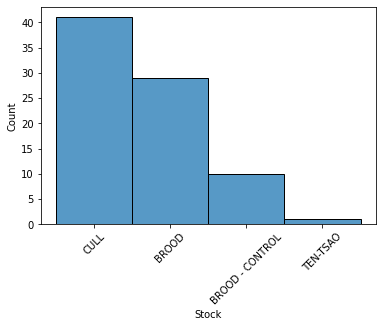

In [8]:
sns.histplot(raw_df, x='Stock')
_ = plt.xticks(rotation=45)

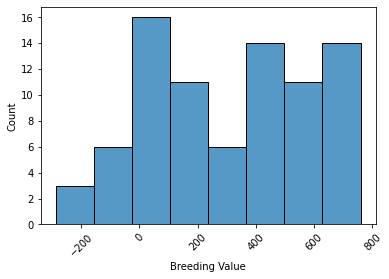

In [9]:
sns.histplot(raw_df, x='Breeding Value')
_ = plt.xticks(rotation=45)

## Data Cleaning

In [11]:
# def rename(name):
#     if 'BROOD' in name:
#         return 'BROOD'
#     elif 'CULL' in name:
#         return 'CULL'
#     else:
#         return name
# raw_df['Stock'] = raw_df['Stock'].apply(rename) # Rename

In [12]:
# The Brood class has different 'Brood' names which needs to be standardized
# According to Erin Legacki, 'Brood Control' NOT selected based on breeding value
# As a result, we will only take those explicitly labeled BROOD and CULL

In [13]:
indices = raw_df[ 
    (raw_df['Stock'] != 'BROOD') &
    (raw_df['Stock'] != 'CULL')
].index
raw_df.drop(indices, inplace=True) # Remove other categories

In [14]:
X_raw = raw_df.drop(['Stock', 'Breeding Value'], axis=1).values
features = raw_df.drop(['Stock', 'Breeding Value'], axis=1).columns

In [15]:
raw_df.head()

,Stock,Breeding Value,B7_4994,B7_4875,B7_4525,B7_3616,B7_3503,B7_3393,B7_1522,B7_1093,...,B0_9047,B0_8992,B0_8938,B0_8825,B0_8759,B0_8651,B0_8562,B0_8515,B0_1677,B0_1468
0,CULL,397.0,131305.45310,144981.26560,142388.8281,96999.42188,156190.8125,95217.79688,29787.84375,112778.8594,...,110548.06250,122697.2656,139708.01560,103893.0625,246991.5469,215101.6875,65581.21875,26646.21875,86967.81250,20274.75000
1,CULL,-91.0,183441.31250,209126.93750,201864.0625,127183.81250,206881.2188,117774.50000,18977.25000,165255.5625,...,110431.21880,121501.6875,125174.62500,89302.8125,214140.1250,212868.2813,65850.68750,27119.37500,71080.46875,35608.62500
2,CULL,344.0,206015.93750,255455.95310,262075.8125,139335.82810,237417.7188,151135.73440,15748.59375,205730.3125,...,256810.57810,265815.4219,260946.79690,178281.7656,414871.1250,377639.4219,109138.48440,54492.51563,81977.62500,18493.96875
3,CULL,132.0,7692.09375,24164.28125,8611.9375,17506.75000,5935.1250,32927.78125,15251.34375,-13094.3125,...,71889.03125,69318.4375,86390.09375,53759.6250,138607.2500,153938.9063,46037.78125,9949.40625,69577.68750,30906.34375
4,CULL,81.0,123934.34380,135644.43750,130603.5625,66523.73438,131626.4375,76109.89063,31055.37500,101598.0000,...,135593.29690,144686.1406,149021.18750,102828.2969,245571.5469,234731.1563,61604.43750,27374.95313,74492.90625,26447.07813


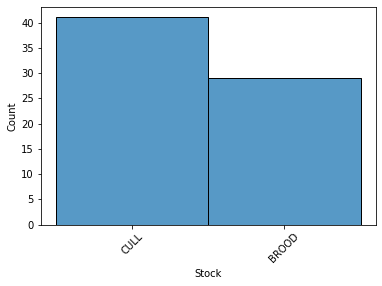

In [16]:
sns.histplot(raw_df, x='Stock')
_ = plt.xticks(rotation=45)

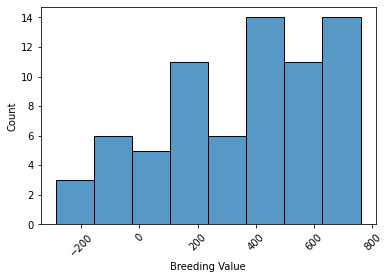

In [17]:
sns.histplot(raw_df, x='Breeding Value')
_ = plt.xticks(rotation=45)

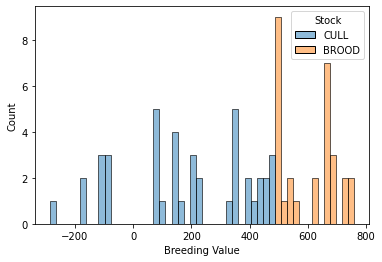

In [18]:
_ = sns.histplot(data=raw_df, hue='Stock', x='Breeding Value', bins=50)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def random_forest_importances(X, y, columns, test_size=0.2, n_estimators=100, ax=None):
    """
    Preliminary estimate of feature importance based on random forests.
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=feature%20importance#sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    forest.fit(X_train, y_train) # Tree-based classifiers do not need scaling/normalization

    importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(18,4))
        importance_df = pd.DataFrame(
            columns=['Feature', 'Importance'],
            data=importances,
        )
        plt.xticks(rotation=45)
        _ = sns.barplot(data=importance_df, x='Feature', y='Importance', ax=ax, orient='v')

    ax.set_xlabel('Feature Number')
    ax.set_ylabel('RF Feature Importance')

    return importances

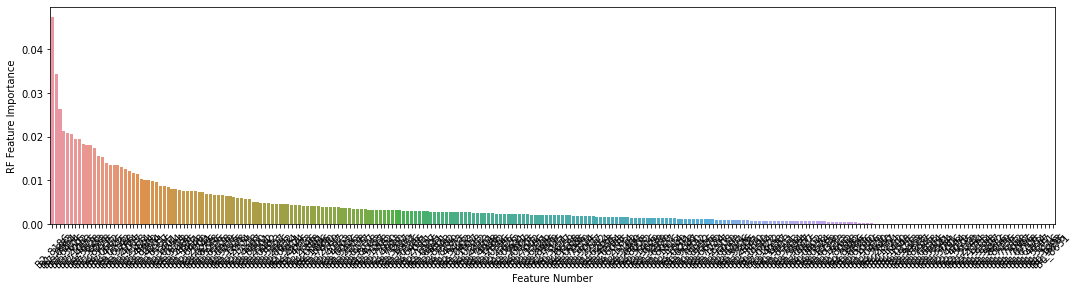

In [20]:
importances = random_forest_importances(
    X=X_raw,
    y=raw_df['Stock'],
    columns=features
)

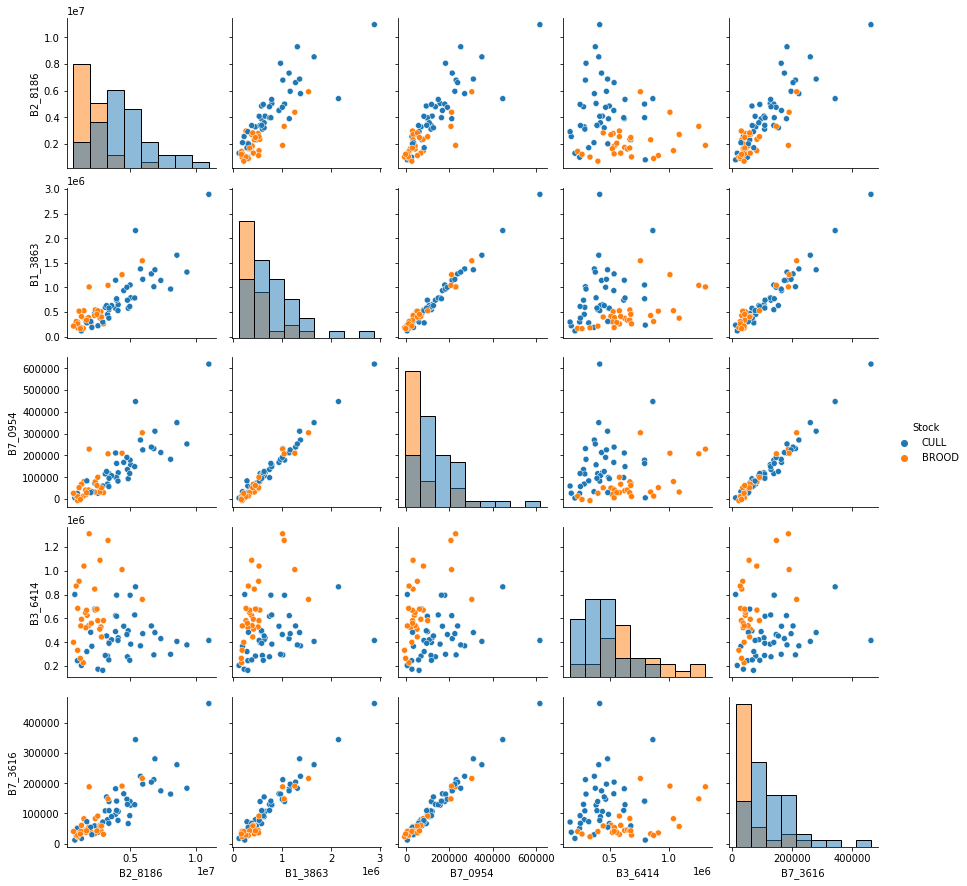

In [21]:
# Some pairwise separation, but also plenty of overlap.  This might be a bit tricky.
sns.pairplot(raw_df, 
             vars=[x_[0] for x_ in importances[:5]],
             diag_kind='hist', 
             hue='Stock')

## Simple Models

Text(0.5, 1.0, 'LDA')

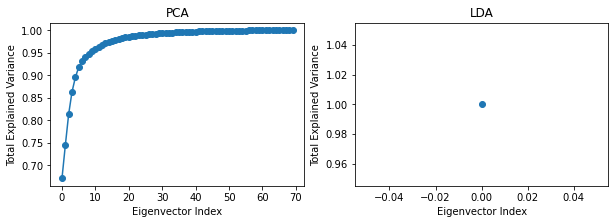

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler

lda = LDA(solver='svd', shrinkage=None, n_components=1)
pca = PCA(whiten=False, random_state=0)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_raw)

lda.fit(X_scaled, raw_df['Stock'])
pca.fit(X_scaled)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = axes.flatten()

ax[0].plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax[0].set_ylabel('Total Explained Variance')
ax[0].set_xlabel('Eigenvector Index')
ax[0].set_title('PCA')

ax[1].plot(np.cumsum(lda.explained_variance_ratio_), '-o')
ax[1].set_ylabel('Total Explained Variance')
ax[1].set_xlabel('Eigenvector Index')
ax[1].set_title('LDA')

In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


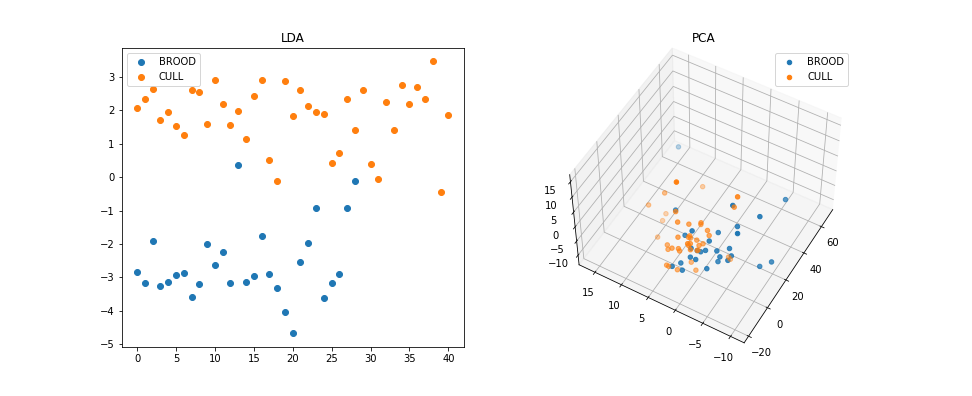

In [25]:
# LDA (supervised) separates well in a few dimensions, PCA (unsupervised) does not

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

X_new_lda = lda.transform(X_scaled)
X_new_pca = pca.transform(X_scaled)

ax = fig.add_subplot(121)
ax.set_title('LDA')
for stock in ['BROOD', 'CULL']:
    x_ = X_new_lda[raw_df['Stock'].values == stock,:]
    ax.scatter(x=np.arange(len(x_)), y=x_[:,0], label=stock)
plt.legend(loc='best')

ax = fig.add_subplot(122, projection='3d')
ax.set_title('PCA')
for stock in ['BROOD', 'CULL']:
    x_ = X_new_pca[raw_df['Stock'].values == stock,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label=stock)
plt.legend(loc='best')

In [26]:
# LDA looks promising. In this case, we have exactly 2 known categories: BROOD and CULL. It is reasonable to 
# build a discrimination model since these are the ONLY possibilities. However, we could also train authentication
# models as well.

# Brood vs. Cull Classification Task

In [27]:
%matplotlib inline

In [28]:
y_raw = raw_df['Stock'].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                        X_raw, 
                                        y_raw, 
                                        test_size=0.2, 
                                        random_state=0, 
                                        stratify=y_raw
                                    )

## LDA Model

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from chemometrics.preprocessing.scaling import CorrectedScaler

### Train Model

In [30]:
scaler = CorrectedScaler(
         with_mean=True,
         with_std=True,
         pareto=False,
         biased=False
     )
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LDA(n_components=1) # LDA cannot exceed n_classes - 1 = 2 - 1 = 1 - no need for grid search CV

_ = model.fit(X_train_scaled, y_train)

In [31]:
print('LDA model has score (train) = {}, score (test) = {}'.format(
    '%.4f'%model.score(X_train_scaled, y_train),
    '%.4f'%model.score(X_test_scaled, y_test))
)

LDA model has score (train) = 0.9464, score (test) = 1.0000


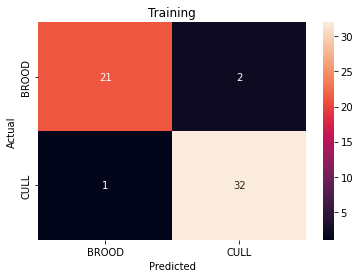

In [32]:
ax = plot_confusion_matrix(model, X_train_scaled, y_train)
_ = plt.title("Training")

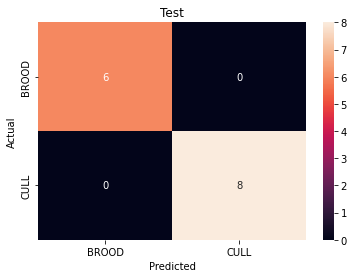

In [33]:
_ = plot_confusion_matrix(model, X_test_scaled, y_test, ax=ax)
_ = plt.title("Test")

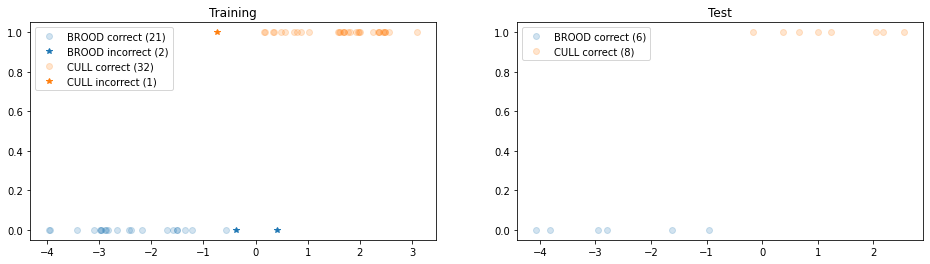

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

for i, class_ in enumerate(['BROOD', 'CULL']):
    mask = y_train == class_
    X_ = X_train_scaled[mask]
    correct = model.predict(X_) == class_
    axes[0].plot(model.transform(X_[correct]), [i]*np.sum(correct), 'o', alpha=0.2, color='C{}'.format(i),
             label=class_+' correct ({})'.format(np.sum(correct)))
    if np.sum(~correct) > 0:
        axes[0].plot(model.transform(X_[~correct]), [i]*np.sum(~correct), '*', alpha=1.0, color='C{}'.format(i),
                 label=class_+' incorrect ({})'.format(np.sum(~correct)))
axes[0].legend(loc='best')
_ = axes[0].set_title("Training")

for i, class_ in enumerate(['BROOD', 'CULL']):
    mask = y_test == class_
    X_ = X_test_scaled[mask]
    correct = model.predict(X_) == class_
    axes[1].plot(model.transform(X_[correct]), [i]*np.sum(correct), 'o', alpha=0.2, color='C{}'.format(i),
             label=class_+' correct ({})'.format(np.sum(correct)))
    if np.sum(~correct) > 0:
        axes[1].plot(model.transform(X_[~correct]), [i]*np.sum(~correct), '*', alpha=1.0, color='C{}'.format(i),
             label=class_+' incorrect ({})'.format(np.sum(~correct)))
axes[1].legend(loc='best')
_ = axes[1].set_title("Test")

### SHAP Explanations

In [36]:
explainer = shap.KernelExplainer(
    model = model.predict_proba, 
    data = X_train_scaled
)

In [37]:
model.classes_

array(['BROOD', 'CULL'], dtype='<U5')

In [38]:
explainer.expected_value

array([0.39494079, 0.60505921])

In [39]:
shap_values_train = explainer.shap_values(X_train_scaled, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train_scaled.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

  0%|          | 0/56 [00:00<?, ?it/s]

In [40]:
shap_values_test = explainer.shap_values(X_test_scaled, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_test_scaled.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

  0%|          | 0/14 [00:00<?, ?it/s]

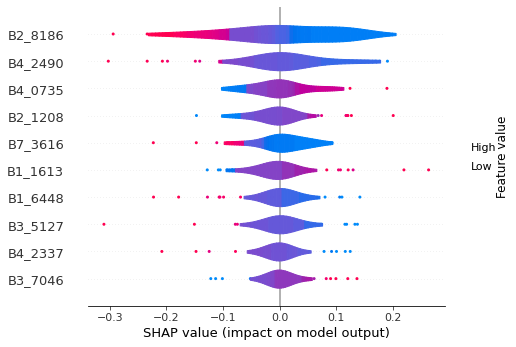

<Figure size 432x288 with 0 Axes>

In [41]:
fig = plt.figure(figsize=(10,6))

shap.summary_plot(
    shap_values=shap_values_train[0], # Look at BROOD - since CULL is complementary the feature importance ordering doesn't seem to matter
    features=X_train_scaled,
    feature_names=features,
    plot_type='violin',
    max_display=10
)
plt.tight_layout()

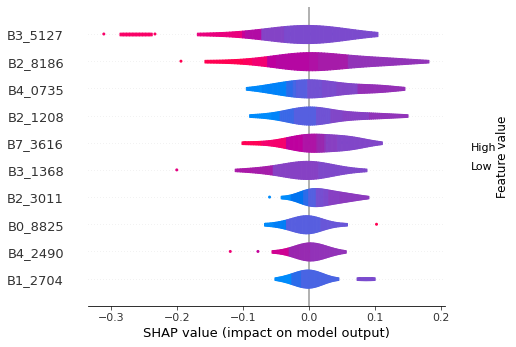

<Figure size 432x288 with 0 Axes>

In [42]:
fig = plt.figure(figsize=(10,6))

shap.summary_plot(
    shap_values=shap_values_test[0], # Look at BROOD
    features=X_test_scaled,
    feature_names=features,
    plot_type='violin',
    max_display=10
)
plt.tight_layout()

In [43]:
# The leading features from LDA coef_ agree loosely with SHAP training

lda_importance = sorted(list(zip(np.abs(model.coef_[0]), features)), key=lambda x:x[0], reverse=True)
lda_importance[:10]

[(3.2400153468002886, 'B4_2490'),
 (2.736894631335563, 'B1_6448'),
 (2.720826609382173, 'B2_8186'),
 (2.4265311167368107, 'B3_5127'),
 (2.4039921090257867, 'B2_1208'),
 (2.2395842231167435, 'B3_1368'),
 (2.2329193985616165, 'B1_1613'),
 (2.226936088311499, 'B4_2337'),
 (1.9830479057142085, 'B4_0735'),
 (1.9723841955339543, 'B1_0429')]

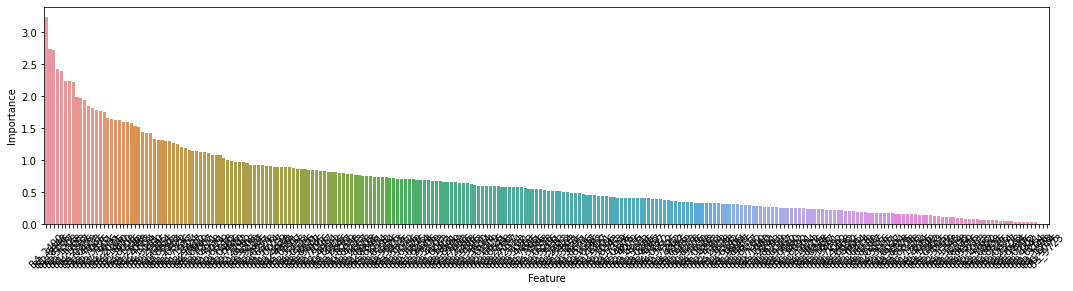

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
importance_df = pd.DataFrame(
    columns=['Importance', 'Feature'],
    data=lda_importance,
)
plt.xticks(rotation=45)
_ = sns.barplot(data=importance_df, x='Feature', y='Importance', ax=ax, orient='v')

### Look at "Incorrect" Predictions

In [46]:
# 2 samples in the confusion matrix above are BROOD, but predicted to be CULL.  Let's examine these:
examine = 'BROOD'
mask = y_train == examine

X_pred = model.predict(X_train_scaled[mask])
incorrect = X_pred != y_train[mask]

In [47]:
incorrect

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False])

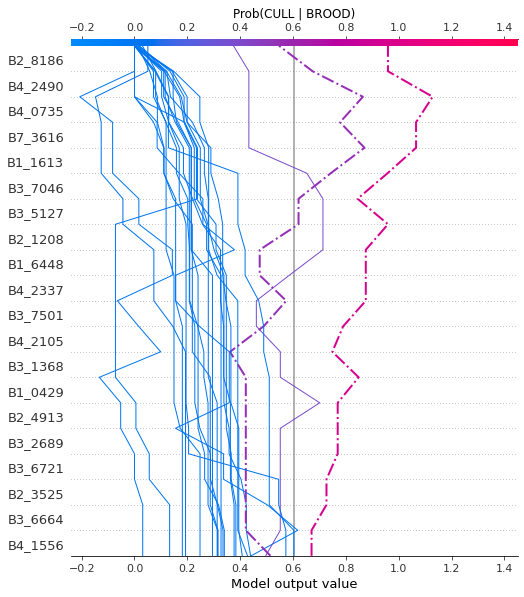

In [49]:
plt.figure()
plt.title('Prob(CULL | BROOD)')
shap.decision_plot(
    explainer.expected_value[1], # CULL is class 1 in model
    shap_values_train[1][mask], 
    feature_names=features.tolist(),
    highlight=incorrect,
)

In [69]:
# This is not great - the model is very confident in one case that it should be CULL even though it is BROOD.
# The other case is more moderate and seems like it is "intertwined" with the correct answers early on;
# more data might fix that.

# However, an alternative explanation is that a bad choice was made SHOULD be CULL but were assigned
# BROOD instead.

In [50]:
# 1 sample in the confusion matrix above is CULL, but predicted to be BROOD.  Let's examine this one:
examine = 'CULL'
mask = y_train == examine

X_pred = model.predict(X_train_scaled[mask])
incorrect = X_pred != y_train[mask]

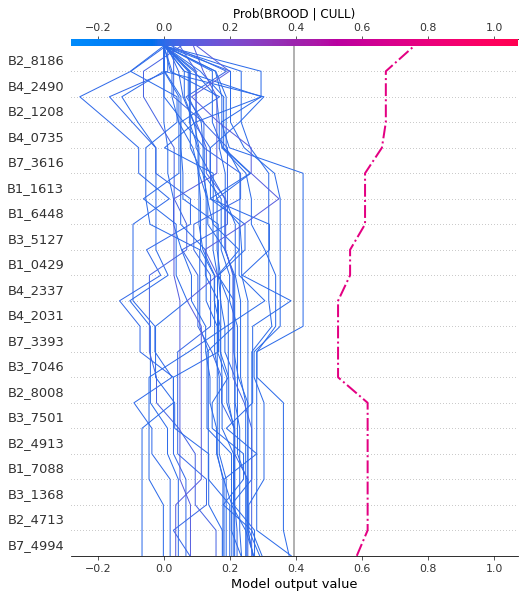

In [51]:
plt.figure()
plt.title('Prob(BROOD | CULL)')
shap.decision_plot(
    explainer.expected_value[0], # BROOD is class 0 in model
    shap_values_train[0][mask], 
    feature_names=features.tolist(),
    highlight=incorrect,
    feature_display_range=None, #slice(-1, -100, -1)
)

In [72]:
# Again, the model is VERY confident the "incorrect" sample should actually be BROOD not CULL, as it is 
# labeled.  Perhaps this was a bad label or decision?  The model is very confident about the others
# (correctly) so this could be interpreted as evidence that the model has correctly figured out how to
# classify these samples and this IS a bad choice on behalf of the managers; OR there could be other
# factors at play and perhaps the model is truly wrong.

### Diagnostics

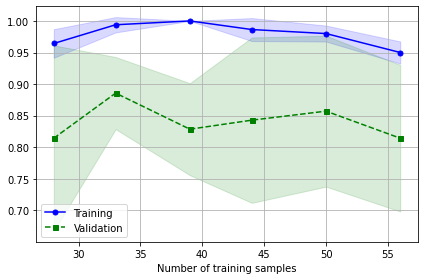

In [52]:
scaler = CorrectedScaler(with_mean=True, with_std=True, pareto=False, biased=False)

_ = plot_learning_curve(
    model=model, 
    X=scaler.fit_transform(X_raw), 
    y=y_raw, 
    cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

In [74]:
# These curves flatten out but do not converge. This suggests the LDA model has a high variance.
# This seems to be a strange conclusion since the LDA model seems simple, but if there is not enough
# data to consistently compute the coefficients on the PC axes, this can lead to high "variance."

# This means we should collect more data or simplify the model. Since the model is fairly simple (1D)
# this is evidence the former should be done.  This could help explain whether or not the model is
# making the "right" call in CULL vs. BROOD examples investigated with SHAP, or if the managers are
# correct and the model is missing something.

## PLS-DA (Discrimination) Model

In [53]:
from chemometrics.classifier.plsda import PLSDA

### Optimize Model

In [54]:
# Data scaling is handled internally in the PLSDA model

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='hard', # This is a discrimination task
                    score_metric='TEFF'
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'plsda__n_components':np.arange(1, 20, 2),
    'plsda__alpha': [0.05, 0.01], # Try a few alpha values to see
    'plsda__scale_x': [True, False], 
    'plsda__style': ['soft', 'hard']
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [55]:
gs.best_params_ # These parameters make sense - note that the 'hard' version was selected over the soft

{'plsda__alpha': 0.05,
 'plsda__n_components': 3,
 'plsda__scale_x': True,
 'plsda__style': 'hard'}

In [67]:
pred = gs.predict(X_train)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(pred, y_train)

In [68]:
df # LDA was a little better on training set, but this could be specific to the split chosen

,BROOD,CULL,UNKNOWN
BROOD,20,3,0
CULL,3,30,0


In [56]:
pred = gs.predict(X_test)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(pred, y_test)

In [57]:
df # This is actually identical to the LDA model we found above!

,BROOD,CULL,UNKNOWN
BROOD,6,0,0
CULL,0,8,0


In [58]:
print('Best PLSDA model has TEFF (train) = {}, TEFF (test) = {}'.format(
    '%.4f'%gs.score(X_train, y_train),
    '%.4f'%gs.score(X_test, y_test))
)

Best PLSDA model has TEFF (train) = 0.8929, TEFF (test) = 1.0000


<AxesSubplot:xlabel='sPC1'>

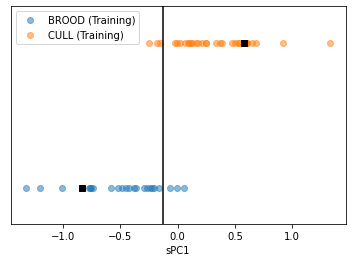

In [59]:
gs.best_estimator_.named_steps['plsda'].visualize()

### SHAP Explanations

In [60]:
explainer = shap.KernelExplainer(
    model = gs.predict_proba, 
    data = X_train
)

In [61]:
explainer.expected_value 
# These are functions of Mahalanobis distances.  For a hard model, it is just the smallest distance
# or highest probability that corresponds to the prediction

array([0.46076557, 0.53923443])

In [62]:
pred_prob_ = gs.predict_proba(X_train)
direct_preds_ = np.array(gs.predict(X_train)).ravel() == 'BROOD'
np.all( (pred_prob_[:,0] > pred_prob_[:,1]) == direct_preds_ )

True

In [63]:
shap_values_train = explainer.shap_values(X_train, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

  0%|          | 0/56 [00:00<?, ?it/s]

In [64]:
shap_values_test = explainer.shap_values(X_test, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_test.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

  0%|          | 0/14 [00:00<?, ?it/s]

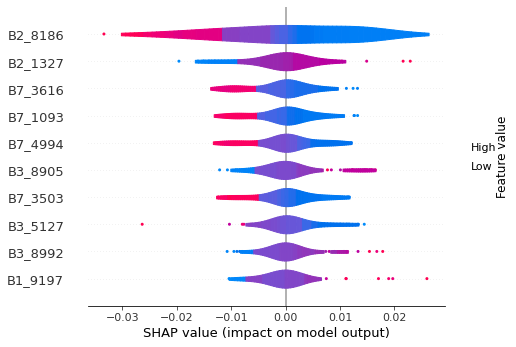

<Figure size 432x288 with 0 Axes>

In [65]:
fig = plt.figure(figsize=(10,6))

shap.summary_plot(
    shap_values=shap_values_train[0], # Look at BROOD 
    features=X_train,
    feature_names=features,
    plot_type='violin',
    max_display=10
)
plt.tight_layout()

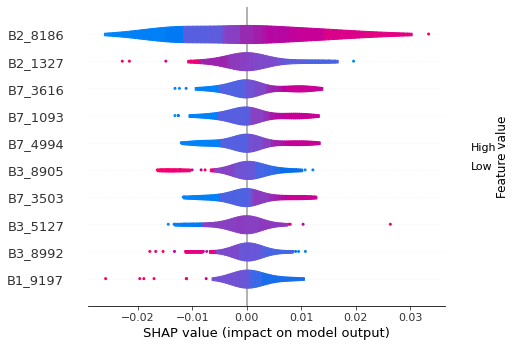

<Figure size 432x288 with 0 Axes>

In [66]:
fig = plt.figure(figsize=(10,6))

shap.summary_plot(
    shap_values=shap_values_train[1], # Look at CULL
    features=X_train,
    feature_names=features,
    plot_type='violin',
    max_display=10
)
plt.tight_layout()

In [69]:
# 8186 is the top feature, similar to LDA, and the same as the initial RF importances.  This is
# definitely something interesting and important!

In [70]:
# 3 samples in the confusion matrix above are BROOD, but predicted to be CULL.  Let's examine these:
examine = 'BROOD'
mask = y_train == examine

X_pred = np.array(gs.predict(X_train[mask])).ravel()
incorrect = X_pred != y_train[mask]

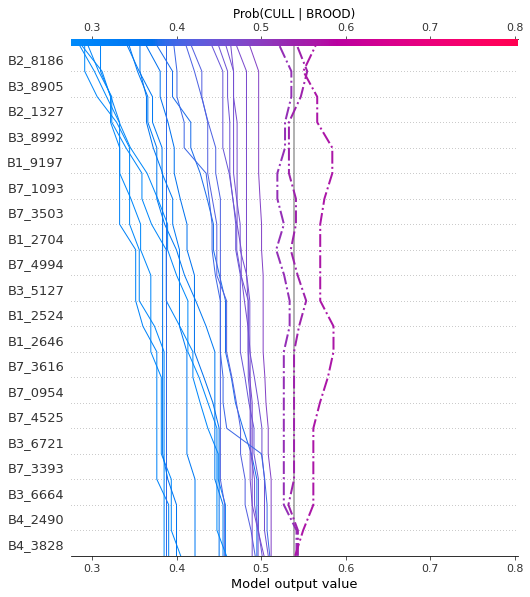

In [71]:
plt.figure()
plt.title('Prob(CULL | BROOD)')
shap.decision_plot(
    explainer.expected_value[1], # CULL is class 1 in model
    shap_values_train[1][mask], 
    feature_names=features.tolist(),
    highlight=incorrect,
)

In [74]:
# The mistakes actually just seem like borderline cases, which is good.  It suggests the model isn't missing
# anything fundamental, it just needs to be a bit more precise. Moreover, the probabilities are "just barely"
# past the threshold (0.5) which is good.

In [75]:
# 3 samples in the confusion matrix above are CULL, but predicted to be BROOD.  Let's examine these:
examine = 'CULL'
mask = y_train == examine

X_pred = np.array(gs.predict(X_train[mask])).ravel()
incorrect = X_pred != y_train[mask]

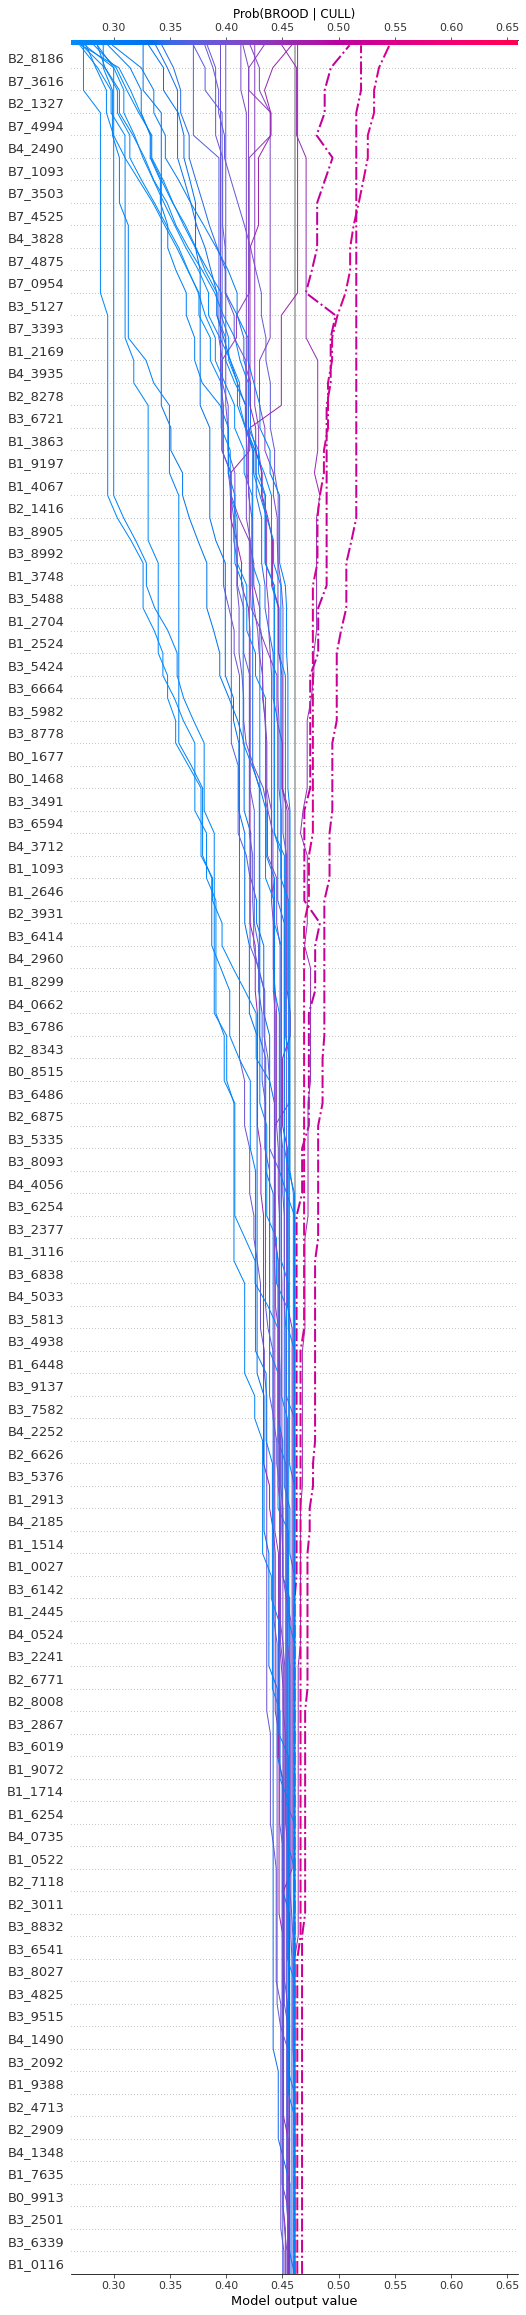

In [77]:
plt.figure()
plt.title('Prob(BROOD | CULL)')
shap.decision_plot(
    explainer.expected_value[0], # BROOD is class 0 in model
    shap_values_train[0][mask], 
    feature_names=features.tolist(),
    highlight=incorrect,
    feature_display_range=slice(-1, -100, -1)
)

In [265]:
# Again, these are edge cases - the model seems to be pretty good!

### Diagnostics

Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iteration 0
invalid value encountered in true_divide
invalid value encountered in long_scalars
Y residual is constant at iterat

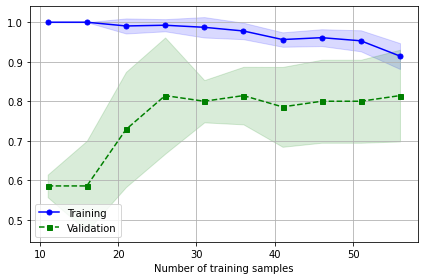

In [79]:
_ = plot_learning_curve(
    model=gs.best_estimator_.named_steps['plsda'], 
    X=X_raw, 
    y=y_raw, 
    cv=5, 
    train_sizes=np.linspace(0.2, 1.0, 10)
)

In [284]:
# More data colllection might be justified - this model is converging, but isn't quite there.  This, along with
# the better performance indicated by SHAP, suggests this model is better than the LDA, even though the
# test performances are identical (and training performance is slightly worse). 

# Breeding Value Regression Task

In [128]:
y_raw = raw_df['Breeding Value'].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                        X_raw, 
                                        y_raw, 
                                        test_size=0.2, 
                                        random_state=0,
                                    )

## Lasso (L1) Linear Regression

In [129]:
from sklearn.linear_model import Lasso

In [154]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaler", CorrectedScaler()),
    ("pca", PCA(n_components=1)),
    ("lasso", Lasso(alpha=0.05))
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'pca__n_components':np.arange(2,50,5),
    'lasso__alpha':np.logspace(-3,3,30)
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [155]:
gs.best_score_ # Very bad!

-0.05568054271274379

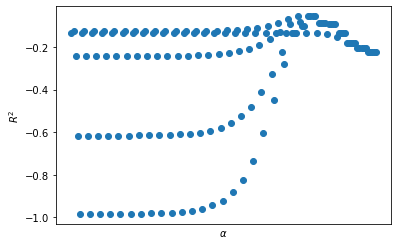

In [159]:
plt.scatter(y=gs.cv_results_['mean_test_score'], x=np.arange(len(gs.cv_results_['mean_test_score'])))
_ = plt.xticks([])
_ = plt.xlabel(r'$\alpha$')
_ = plt.ylabel(r'$R^2$')

In [ ]:
# LASSO uses R^2 for scoring which is bounded by (-np.inf, 1.0].
# A score of ~0  results when you just predict the average(y) value. 
# This model is suggesting that the best it can do is predict the average breeding value score in the
# training set, which implies there is no correlation between breeding value and the X matrix!

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso.score

# Removing PCA, etc. did not change this outcome.

# Perhaps we need a very non-linear model instead? Try a RandomForestRegressor!

## Random Forest Regression

In [160]:
from sklearn.ensemble import RandomForestRegressor

In [167]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaler", CorrectedScaler()),
    ("pca", PCA(n_components=1)),
    ("rf", RandomForestRegressor(
                    n_estimators=100,
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'pca__n_components':np.arange(2, 40, 5),
    'rf__n_estimators':np.arange(10, 100, 20)
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [168]:
gs.best_score_ # Again, very bad!

-0.07988835406509961

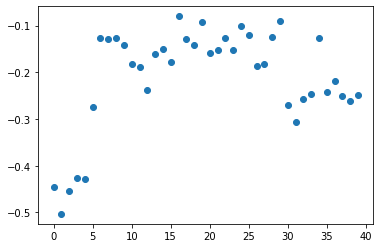

In [169]:
plt.scatter(y=gs.cv_results_['mean_test_score'], x=np.arange(len(gs.cv_results_['mean_test_score'])))

In [ ]:
# The RF was not better.  This leads us to the striking conclusion that there is NO CORRELATION between the
# breeding value and the X matrix!

# Reconciling Regression and Classification

Apparently, there is a connection between the stock class (BROOD vs. CULL) and the chemometric X matrix, but the numerical breeding value is NOT correlated!  Note that BV does seem to split stock disjointly (see below), so there seems to be some kind of connection, but not one that can be resolved quantitatively. It seems that within each class the numerical BV is basically random wrt the X matrix features.

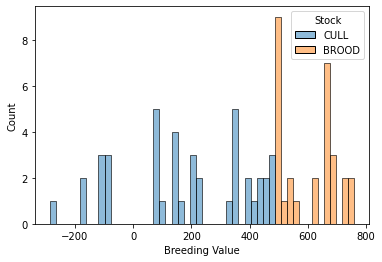

In [171]:
_ = sns.histplot(data=raw_df, hue='Stock', x='Breeding Value', bins=50)

In [172]:
# We can use the Spearman rank-order correlation as a non-parametric measure of correlation between a 
# feature and the BV.

In [209]:
from scipy.stats import spearmanr

alpha = 0.05
sr = {}
for f in features.values:
    c, p = spearmanr(raw_df[f], raw_df['Breeding Value'])
    if p < alpha: # Only look at statistically significant ones
        sr[f] = (c, p)
        
# Let's just look at the top 5
# (feature, (spearman_r, alpha))
sorted([(k,v) for (k,v) in sr.items()], key=lambda x:np.abs(x[1][0]), reverse=True)[:5]

[('B3_2092', (0.5187519746812317, 4.214316449875949e-06)),
 ('B3_5335', (0.48472282540570216, 2.1164994468335316e-05)),
 ('B3_6254', (0.4833749630115583, 2.2483764620055756e-05)),
 ('B4_0662', (0.48325243006663615, 2.260736783346281e-05)),
 ('B3_2974', (0.4759354627841406, 3.124576595280441e-05))]

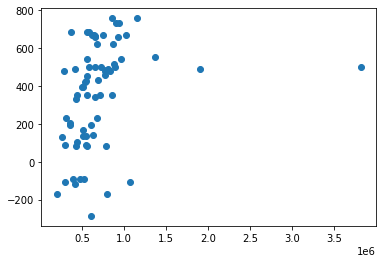

In [189]:
# Examine them - they are essentially just "vertical" plots showing little to no correlation between x and y
plt.plot(raw_df['B3_2092'], raw_df['Breeding Value'], 'o')

In [205]:
# We can try to regress the feature vs. BV to see how that does. Here I will just use the entire set 
# instead of breaking it into test/train for illustration purposes only.
from sklearn.linear_model import LinearRegression as LR
for row in sorted([(k,v) for (k,v) in sr.items()], key=lambda x:np.abs(x[1][0]), reverse=True)[:5]:
    lr = LR()
    X_, y_ = raw_df[row[0]].values.reshape(-1,1), raw_df['Breeding Value']
    lr.fit(X_, y_)
    print('R^2 (BV vs. {}) = {}'.format(row[0], lr.score(X_, y_)))
    
# These are better than 0, but only a bit.  Plus, these are evaluated on the data they were trained on
# so these are not to be taken as rigorous.

R^2 (BV vs. B3_2092) = 0.08409986706925332
R^2 (BV vs. B3_5335) = 0.16216778345406369
R^2 (BV vs. B3_6254) = 0.1740822168928602
R^2 (BV vs. B4_0662) = 0.1607669042196015
R^2 (BV vs. B3_2974) = 0.11975120455971078


In [208]:
# We could also try combining a few features, but clearly it does not help.
lr = LR()
X_, y_ = raw_df[['B3_2092', 'B3_5335', 'B3_6254', 'B4_0662', 'B3_2974']].values, raw_df['Breeding Value']
lr.fit(X_, y_)
lr.score(X_, y_)

0.183571587947017

In [210]:
lr = LR()
X_, y_ = raw_df[['B2_8186']].values.reshape(-1,1), raw_df['Breeding Value']
lr.fit(X_, y_)
lr.score(X_, y_)

0.11429062029435